In [1]:
# TODO
# Visualizing the demand?
# Share of annual output per storage technology
# more comprehensive correlation analysis: n technologies with most generation / consumption and their generation and capacity correlation

## Imports

In [57]:
import pandas as pd
import geopandas as gpd
import numpy as np
import pypsa
import math
import seaborn as sns
import cartopy
import cartopy.crs as ccrs
import matplotlib
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from shapely.geometry import Point, LineString
from datetime import datetime
import matplotlib.patheffects as pe
import matplotlib.colors as mcolors

from datetime import date, datetime, time, timedelta

# imported own functions
from utils import market_values, market_values_by_time_index, nodal_balance, capacity, capacity_links, capacity_storage_units, get_condense_sum, nodal_balance, generation, generation_links, generation_storage_units, market_values_storage_units, market_values_links, time_stored_LIFO

# imported own definitions
from utils import carrier_colors, carrier_renaming, carrier_renaming_reverse, resistive_heater, gas_boiler, heat_pump, water_tanks_charger, water_tanks_discharger, solar_thermal
from utils import c_el_gen_s, c_el_con_s

# general variables
font1 = {'fontname':'Calibri'}
PLOT_DIR = 'C:/Users/Julian/Studies/Master/01 TU Berlin/3. Semester - Masterarbeit/MA Marktwerte FEE/data/plots/'
onshore_regions = gpd.read_file("../data/external/regions_onshore_elec_s_181.geojson")
offshore_regions = gpd.read_file("../data/external/regions_offshore_elec_s_181.geojson")
onshore_regions = onshore_regions.set_index('name')
offshore_regions = offshore_regions.set_index('name')

In [3]:
# Network imports
n_no =pypsa.Network("../data/raw/elec_s_181_lv1.0__Co2L0-3H-T-H-B-I-A-solar+p3-linemaxext10-noH2network_2030.nc")
n_h2 =pypsa.Network("../data/raw/elec_s_181_lvopt__Co2L0-3H-T-H-B-I-A-solar+p3-linemaxext10_2030.nc")

Importing PyPSA from older version of PyPSA than current version.
Please read the release notes at https://pypsa.readthedocs.io/en/latest/release_notes.html
carefully to prepare your network for import.
Currently used PyPSA version [0, 20, 1], imported network file PyPSA version [0, 18, 1].

INFO:pypsa.io:Imported network elec_s_181_lv1.0__Co2L0-3H-T-H-B-I-A-solar+p3-linemaxext10-noH2network_2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
Importing PyPSA from older version of PyPSA than current version.
Please read the release notes at https://pypsa.readthedocs.io/en/latest/release_notes.html
carefully to prepare your network for import.
Currently used PyPSA version [0, 20, 1], imported network file PyPSA version [0, 18, 1].

INFO:pypsa.io:Imported network elec_s_181_lvopt__Co2L0-3H-T-H-B-I-A-solar+p3-linemaxext10_2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [119]:
# stst and exp dataframes
# spatial
df_stst_ons = pd.read_pickle("../data/processed/df_stst_ons.pkl")
df_stst_off = pd.read_pickle("../data/processed/df_stst_off.pkl")
df_exp_ons = pd.read_pickle("../data/processed/df_exp_ons.pkl")
df_exp_off = pd.read_pickle("../data/processed/df_exp_off.pkl")

# temporal
df_stst_ts = pd.read_pickle("../data/processed/df_stst_ts.pkl")
df_exp_ts = pd.read_pickle("../data/processed/df_exp_ts.pkl")

In [4]:
# Notebook Definitions
c1_groups = [resistive_heater, gas_boiler, heat_pump, water_tanks_charger, water_tanks_discharger, solar_thermal]
c1_groups_name = ["resistive heater", "gas boiler", "heat pump", "water tanks charger", "water tanks discharger", "solar thermal"]
markers =["v", "^", "<", ">", "1", "2", "3", "4", "*", "+", "d", "o", "|", "s", "P", "p", "h"]

In [5]:
# Notebook Functions

def get_df(df_no, df_h2, carriers):
    result = pd.DataFrame(index = ["STST", "EXP"])

    for c in carriers:
        result.loc["STST" , c] = df_no[c].values
        result.loc["EXP" , c] = df_h2[c].values
    return result

def c_gen(carrier_list, network):
    result = []
    for c in carrier_list:
        if c in network.generators.carrier.unique().tolist():
            result.append(c)
    return result

def c_link(carrier_list, network):
    result = []
    for c in carrier_list:
        if c in network.links.carrier.unique().tolist():
            result.append(c)
    return result

def c_su(carrier_list, network):
    result = []
    for c in carrier_list:
        if c in network.storage_units.carrier.unique().tolist():
            result.append(c)
    return result

In [6]:
# Regions

onshore_regions['coords'] = onshore_regions['geometry'].apply(lambda x: x.representative_point().coords[:])
onshore_regions['coords'] = [coords[0] for coords in onshore_regions['coords']]
onshore_regions["name"] = onshore_regions.index
offshore_regions['coords'] = offshore_regions['geometry'].apply(lambda x: x.representative_point().coords[:])
offshore_regions['coords'] = [coords[0] for coords in offshore_regions['coords']]
offshore_regions["name"] = offshore_regions.index

## CALC

In [7]:
# calc market values, generation, lmps, capacity factors for generators, links and storage units

for n in [n_no, n_h2]:
    df_regions_onshore = onshore_regions.copy()
    df_regions_offshore = offshore_regions.copy()

    # function for carriers in n.generators.carrier.unique() #13
    for carrier in n.generators.carrier.unique():
        df_regions_onshore[f"{carrier}_mv"] = market_values(n, carrier)
        df_regions_offshore[f"{carrier}_mv"] = market_values(n, carrier)
        # generation in TWh (does this have to be multiplied by 3??
        df_regions_onshore[f"{carrier}_gen"] = generation(n, carrier) / 1000
        df_regions_offshore[f"{carrier}_gen"] = generation(n, carrier) / 1000
        # lmps
        # capacity factors This calculation is correct? as capacity is multiplied by 2920 is the same as multiplying the generation by 3 and then dividing it by the capacity times 8760 (as cap is in MWh?)
        df_regions_onshore[f"{carrier}_cf"] = generation(n, carrier) / (capacity(n, carrier) *2920)
        df_regions_offshore[f"{carrier}_cf"] = generation(n, carrier) / (capacity(n, carrier) *2920)


    # function for carriers in n.links.carrier.unique() #53
    for carrier in n.links.carrier.unique():
        df_regions_onshore[f"{carrier}_mv"] = market_values_links(n, carrier)
        df_regions_onshore[f"{carrier}_gen"] = generation_links(n, carrier) / 1000
        df_regions_onshore[f"{carrier}_cf"] = generation_links(n, carrier) / (capacity_links(n, carrier) *2920)

    # function for carriers in n.storage_units.carrier.unique() #2
    for carrier in n.storage_units.carrier.unique():
        df_regions_onshore[f"{carrier}_mv"] = market_values_storage_units(n, carrier)
        df_regions_onshore[f"{carrier}_gen"] = generation_storage_units(n, carrier) / 1000
        # capacity factors (both generation and consumption(loading) is considered
        gen = abs(n.storage_units_t.p.loc[:, n.storage_units.carrier == carrier])
        gen.columns = gen.columns.map(n.storage_units.bus)
        gen.columns = gen.columns.map(n.buses.location)
        df_regions_onshore[f"{carrier}_cf"] = gen.sum() / (capacity_storage_units(n, carrier) *2920)

    # set market values to nan where generation in corresponding region is lower than % quantile
    qt = 0.2
    for carrier in (n.generators.carrier.unique().tolist() +
                    n.links.carrier.unique().tolist() +
                    n.storage_units.carrier.unique().tolist()):
        index = df_regions_onshore[f"{carrier}_gen"] <= np.quantile(df_regions_onshore[f"{carrier}_gen"], qt)
        df_regions_onshore[f"{carrier}_mv"][index] = np.nan

    # calc lmps at the buses (lmps that are only present for EU (e.g. oil) are nan at the moment)
    # TODO: decide if EU lmps are used as lmp for all regions
    for carrier_bus in n.buses.carrier.unique():
        # index would be same names as the bus (not the location as it is in the index of
        # df_regions_onshore so far -> map location to make sure the right lmp is set
        locs = n.buses.location[n.buses[n.buses.carrier == carrier_bus].index]
        lmps = n.buses_t.marginal_price[n.buses[n.buses.carrier == carrier_bus].index].mean()
        df = pd.concat([lmps, locs], axis=1).rename(columns={0: f"{carrier_bus}_lmp"})
        df.set_index("location", inplace=True)
        if df.size == 1:
            if df.index == "EU":
                df = pd.DataFrame(np.repeat(df.values, 181), index=df_regions_onshore.index, columns=[f"{carrier_bus}_lmp"])
                df_regions_onshore[f"{carrier_bus}_lmp"] = df[f"{carrier_bus}_lmp"]
        else:
            df_regions_onshore[f"{carrier_bus}_lmp"] = df[f"{carrier_bus}_lmp"]

    if n == n_no:
        df_no_ons = df_regions_onshore
        df_no_off = df_regions_offshore

    if n == n_h2:
        df_h2_ons = df_regions_onshore
        df_h2_off = df_regions_offshore

df_no_ons.head()

,geometry,coords,name,offwind-ac_mv,offwind-ac_gen,offwind-ac_cf,onwind_mv,onwind_gen,onwind_cf,solar_mv,...,urban central water tanks_lmp,biogas_lmp,solid biomass_lmp,solid biomass for industry_lmp,gas for industry_lmp,H2 liquid_lmp,oil_lmp,process emissions_lmp,low voltage_lmp,home battery_lmp
name,,,,,,,,,,,,,,,,,,,,,
AL0 0,"POLYGON ((20.32207 39.91318, 20.39703 39.81809...","(20.00648437943388, 41.14563914300007)",AL0 0,126.148417,0.009746,0.090705,NaN,0.005042,0.038018,44.628736,...,43.532557,113.716896,102.453861,78.924392,113.135704,137.617875,50.009981,-408.520212,100.338046,100.380697
AT0 0,"POLYGON ((16.45660 47.41184, 16.43396 47.39685...","(15.700718667666258, 47.896990619088925)",AT0 0,NaN,NaN,NaN,83.457109,10131.968084,0.149667,54.679083,...,55.231280,113.716896,102.453861,78.924392,113.135704,151.448316,50.009981,-408.520212,115.006246,115.044440
AT0 1,"POLYGON ((10.08288 47.35907, 10.20928 47.37248...","(10.379200993764837, 47.18231496200006)",AT0 1,NaN,NaN,NaN,NaN,0.000116,0.004685,65.745903,...,55.553668,113.716896,102.453861,78.924392,113.135704,154.026970,50.009981,-408.520212,121.910720,121.947576
AT0 2,"POLYGON ((13.47802 46.56357, 13.23111 46.55217...","(13.805469952867842, 47.57283376100011)",AT0 2,NaN,NaN,NaN,NaN,0.004773,0.039178,58.223787,...,58.936874,113.716896,102.453861,78.924392,113.135704,148.663198,50.009981,-408.520212,112.352878,112.386673
BA0 0,"POLYGON ((17.82716 42.85312, 17.81176 42.90986...","(17.97055162265331, 43.88773569750005)",BA0 0,NaN,NaN,NaN,NaN,0.004686,0.031802,51.160537,...,51.074197,113.716896,102.453861,78.924392,113.135704,147.689672,50.009981,-408.520212,112.040690,112.006725


In [8]:
# calc market values, generation, lmps, capacity factors for generators, links and storage units
df_regions_onshore = onshore_regions.copy()
df_regions_offshore = offshore_regions.copy()
n = n_h2

# function for carriers in n.generators.carrier.unique() #13
for carrier in n.generators.carrier.unique():
    df_regions_onshore[f"{carrier}_mv"] = market_values(n, carrier)
    df_regions_offshore[f"{carrier}_mv"] = market_values(n, carrier)
    # generation in TWh
    df_regions_onshore[f"{carrier}_gen"] = generation(n, carrier) / 1000
    df_regions_offshore[f"{carrier}_gen"] = generation(n, carrier) / 1000
    # lmps
    df_regions_onshore[f"{carrier}_gen"] = generation(n, carrier) / 1000
    df_regions_offshore[f"{carrier}_gen"] = generation(n, carrier) / 1000

# function for carriers in n.links.carrier.unique() #53
for carrier in n.links.carrier.unique():
    df_regions_onshore[f"{carrier}_mv"] = market_values_links(n, carrier)
    df_regions_onshore[f"{carrier}_gen"] = generation_links(n, carrier) / 1000

# function for carriers in n.storage_units.carrier.unique() #2
for carrier in n.storage_units.carrier.unique():
    df_regions_onshore[f"{carrier}_mv"] = market_values_storage_units(n, carrier)
    df_regions_onshore[f"{carrier}_gen"] = generation_storage_units(n, carrier) / 1000

# set market values to nan where generation in corresponding region is lower than % quantile
qt = 0.2
for carrier in (n.generators.carrier.unique().tolist() +
                n.links.carrier.unique().tolist() +
                n.storage_units.carrier.unique().tolist()):
    index = df_regions_onshore[f"{carrier}_gen"] <= np.quantile(df_regions_onshore[f"{carrier}_gen"], qt)
    df_regions_onshore[f"{carrier}_mv"][index] = np.nan

# calc lmps at the buses (lmps that are only present for EU (e.g. oil) are nan at the moment)
# TODO: decide if EU lmps are used as lmp for all regions
for carrier_bus in n.buses.carrier.unique():
    # index would be same names as the bus (not the location as it is in the index of
    # df_regions_onshore so far -> map location to make sure the right lmp is set
    locs = n.buses.location[n.buses[n.buses.carrier == carrier_bus].index]
    lmps = n.buses_t.marginal_price[n.buses[n.buses.carrier == carrier_bus].index].mean()
    df = pd.concat([lmps, locs], axis=1).rename(columns={0: f"{carrier_bus}_lmp"})
    df.set_index("location", inplace=True)
    if df.size == 1:
        if df.index == "EU":
            df = pd.DataFrame(np.repeat(df.values, 181), index=df_regions_onshore.index, columns=[f"{carrier_bus}_lmp"])
            df_regions_onshore[f"{carrier_bus}_lmp"] = df[f"{carrier_bus}_lmp"]
    else:
        df_regions_onshore[f"{carrier_bus}_lmp"] = df[f"{carrier_bus}_lmp"]

df_regions_onshore.head(3)
# df_regions_offshore.head(3)

df_h2_ons = df_regions_onshore
df_h2_off = df_regions_offshore

In [9]:
#assert 0

# 4.1 Overview

## Network Overview

In [10]:
print(n_no)

PyPSA Network
Components:
 - Bus: 3086
 - Carrier: 30
 - Generator: 1707
 - GlobalConstraint: 3
 - Line: 323
 - Link: 8375
 - Load: 2542
 - StorageUnit: 170
 - Store: 1635
Snapshots: 2920


In [11]:
print(n_h2)

PyPSA Network
Components:
 - Bus: 3086
 - Carrier: 30
 - Generator: 1707
 - GlobalConstraint: 2
 - Line: 323
 - Link: 9192
 - Load: 2542
 - StorageUnit: 170
 - Store: 1635
Snapshots: 2920


### Electricity network

In [12]:
m_no = n_no.copy()
m_no.mremove("Bus",m_no.buses[m_no.buses.x == 0].index )

m_h2 = n_h2.copy()
m_h2.mremove("Bus",m_h2.buses[m_h2.buses.x == 0].index )

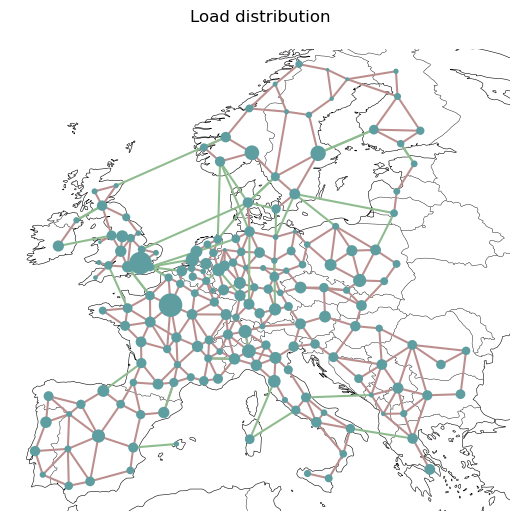

In [13]:
fig, ax = plt.subplots(1, 1, subplot_kw={"projection": ccrs.EqualEarth()}, figsize=(8, 6))

bus_locs = pd.Index(m_no.buses.location.unique())
load_distribution = m_no.loads_t.p[bus_locs].sum()/m_no.loads_t.p[bus_locs].sum().max()

m_no.plot(bus_sizes=1*load_distribution, ax=ax, projection=ccrs.EqualEarth())
ax.set_title("Load distribution", pad=20)
plt.show()
# same for m_h2

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, subplot_kw={"projection": ccrs.EqualEarth()}, figsize=(14, 6))

norm_lines = max(n_no.lines.s_nom_opt.max(), n_h2.lines.s_nom_opt.max(),(n_h2.lines.s_nom_opt - n_no.lines.s_nom_opt).max())
norm_links = max(n_no.links.p_nom_opt[n_no.links.carrier == "DC"].max(), n_h2.links.p_nom_opt[n_h2.links.carrier == "DC"].max(), (n_h2.links.p_nom_opt - n_no.links.p_nom_opt)[n_h2.links.carrier == "DC"].max() )

scale_lines = 7
scale_links = 7

# STST
hvac_weights = n_no.lines.s_nom_opt / norm_lines * scale_lines
hvdc_weights = n_no.links.p_nom_opt.replace(0, 1) / norm_links * scale_links

m_no.plot(ax=ax1, projection=ccrs.EqualEarth(), bus_colors="black", line_colors="gold", link_colors="deepskyblue", line_widths=hvac_weights, link_widths=hvdc_weights )
pypsa.plot.add_legend_patches(ax=ax1, labels=["HVAC lines", "HVDC lines"], colors=["gold","deepskyblue"], legend_kw={'loc': 'upper left'})
ax1.set_title("Electricity grid (STST)", pad=10)

# EXP
hvac_weights = n_h2.lines.s_nom_opt / norm_lines * scale_lines
hvdc_weights = n_h2.links.p_nom_opt.replace(0, 1) / norm_links * scale_links

m_h2.plot(ax=ax2, projection=ccrs.EqualEarth(), bus_colors="black", line_colors="gold", link_colors="deepskyblue", line_widths=hvac_weights, link_widths=hvdc_weights )
pypsa.plot.add_legend_patches(ax=ax2, labels=["HVAC lines", "HVDC lines"], colors=["gold","deepskyblue"], legend_kw={'loc': 'upper left'})
ax2.set_title("Electricity grid (EXP)", pad=10)

fig.tight_layout()
plt.close()
plt.show()

#fig.savefig(f"{PLOT_DIR}01_general/4.1_system_overview/el_grid.png")

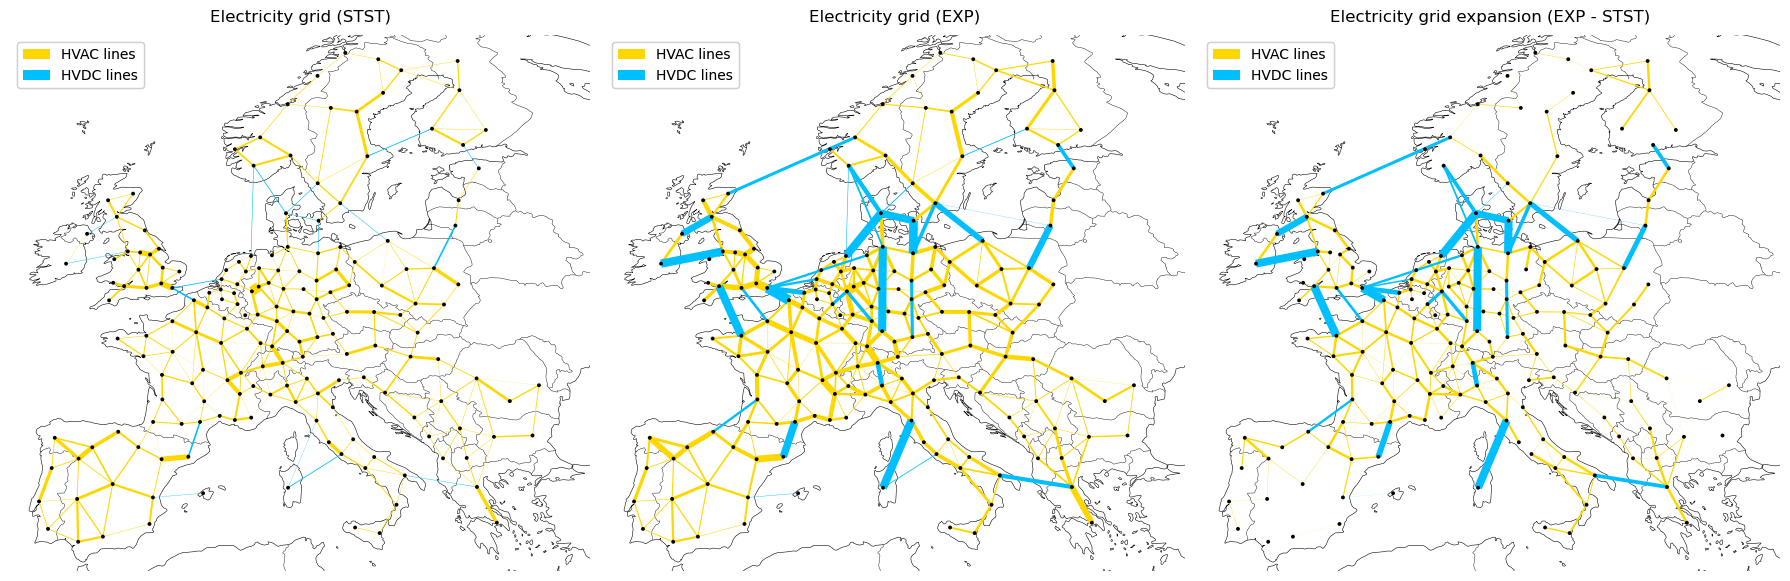

In [15]:
# plot of difference in grid
#TODO: try to give a measurement and include units

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, subplot_kw={"projection": ccrs.EqualEarth()}, figsize=(18, 6))

norm_lines = max(n_no.lines.s_nom_opt.max(), n_h2.lines.s_nom_opt.max(),(n_h2.lines.s_nom_opt - n_no.lines.s_nom_opt).max())
norm_links = max(n_no.links.p_nom_opt[n_no.links.carrier == "DC"].max(), n_h2.links.p_nom_opt[n_h2.links.carrier == "DC"].max(), (n_h2.links.p_nom_opt - n_no.links.p_nom_opt)[n_h2.links.carrier == "DC"].max() )

scale_lines = 7
scale_links = 7

# STST
hvac_weights = n_no.lines.s_nom_opt / norm_lines * scale_lines
hvdc_weights = n_no.links.p_nom_opt.replace(0, 1) / norm_links * scale_links

m_no.plot(ax=ax1, projection=ccrs.EqualEarth(), bus_colors="black", line_colors="gold", link_colors="deepskyblue", line_widths=hvac_weights, link_widths=hvdc_weights )
pypsa.plot.add_legend_patches(ax=ax1, labels=["HVAC lines", "HVDC lines"], colors=["gold","deepskyblue"], legend_kw={'loc': 'upper left'})
ax1.set_title("Electricity grid (STST)", pad=10)

# EXP
hvac_weights = n_h2.lines.s_nom_opt / norm_lines * scale_lines
hvdc_weights = n_h2.links.p_nom_opt.replace(0, 1) / norm_links * scale_links

m_h2.plot(ax=ax2, projection=ccrs.EqualEarth(), bus_colors="black", line_colors="gold", link_colors="deepskyblue", line_widths=hvac_weights, link_widths=hvdc_weights )
pypsa.plot.add_legend_patches(ax=ax2, labels=["HVAC lines", "HVDC lines"], colors=["gold","deepskyblue"], legend_kw={'loc': 'upper left'})
ax2.set_title("Electricity grid (EXP)", pad=10)

# DIFF
hvac_weights = (n_h2.lines.s_nom_opt - n_no.lines.s_nom_opt) / norm_lines * scale_lines
hvdc_weights = (n_h2.links.p_nom_opt - n_no.links.p_nom_opt) / norm_links * scale_links

m_no.plot(ax=ax3, projection=ccrs.EqualEarth(), bus_colors="black", line_colors="gold", link_colors="deepskyblue", line_widths=hvac_weights, link_widths=hvdc_weights )
pypsa.plot.add_legend_patches(ax=ax3, labels=["HVAC lines", "HVDC lines"], colors=["gold","deepskyblue"], legend_kw={'loc': 'upper left'})
ax3.set_title("Electricity grid expansion (EXP - STST)", pad=10)

fig.tight_layout()
plt.show()

#fig.savefig(f"{PLOT_DIR}01_general/4.1_system_overview/el_grid_exp.png")

In [16]:
# AC lines

In [17]:
# all AC network lines are froms same type
n_no.lines.type.unique()

array(['Al/St 240/40 4-bundle 380.0'], dtype=object)

In [18]:
# lines with zero capacity
new_lines = n_no.lines[n_no.lines.s_nom_opt == 0.0].index

In [19]:
# length of HVAC
# STST: 67626.76416683497 km
# EXP: 68396.95599455902 km
n_no.lines.length[~ n_no.lines.index.isin(new_lines)].sum()
n_h2.lines.length.sum()

68396.95599455902

In [20]:
# how much more capacity do the new lines have (exclude ones with 0 in first place)
np.mean(n_h2.lines.s_nom_opt.loc[~ n_h2.lines.index.isin(new_lines)] / n_no.lines.s_nom_opt.loc[~ n_no.lines.index.isin(new_lines)])

2.3883063030537257

In [21]:
# Optimised capacity for apparent power: capacities in megavolt amperes (MVA)
n_h2.lines.s_nom_opt / n_no.lines.s_nom_opt

Line
1      4.390311
2      2.621784
3           inf
4      1.316506
5      1.019110
         ...   
319    1.000001
320    1.000000
321    2.962743
322    1.122132
323    1.000000
Name: s_nom_opt, Length: 323, dtype: float64

In [22]:
# sum of all capacities of all AC lines is almost twice as high for the second network
n_h2.lines.s_nom_opt.sum() / n_no.lines.s_nom_opt.sum()

1.936867546113058

In [23]:
# sum of product of line capacity with length
(n_h2.lines.s_nom_opt*n_h2.lines.length).sum()

620273486.761611

In [24]:
(n_h2.lines.s_nom_opt*n_h2.lines.length).sum() / (n_no.lines.s_nom_opt*n_no.lines.length).sum()

1.9622838082425154

In [25]:
# DC cables

In [26]:
len(n_h2.links[n_h2.links.carrier == "DC"])

42

In [27]:
# all DC cables
n_h2.links[n_h2.links.carrier == "DC"]

,bus0,bus1,carrier,geometry,length,p_nom,tags,under_construction,underground,p_min_pu,...,p_nom_max,p_nom_opt,charger_ratio,type,build_year,p_set,p_max_pu,terrain_factor,ramp_limit_up,ramp_limit_down
Link,,,,,,,,,,,,,,,,,,,,,
14547,IT0 10,GR0 1,DC,"LINESTRING(21.0892517161789 39.3174860744064,2...",540.473320,500.0,,0.0,0.0,-1.0,...,10500.0,5145.515052,NaN,,0,0.0,1.0,1.0,NaN,NaN
5686,ES2 0,ES0 8,DC,"LINESTRING(2.48932993486183 39.561252379133,1....",380.149764,400.0,"""MW""=>""None"", ""TSO""=>""None"", ""oid""=>""32590"", ""...",0.0,0.0,-1.0,...,10400.0,477.168676,NaN,,0,0.0,1.0,1.0,NaN,NaN
14539,ME0 0,IT0 14,DC,"LINESTRING(14.0986517070226 42.4133438660838,1...",560.240709,0.0,,1.0,0.0,-1.0,...,10000.0,0.177441,NaN,,0,0.0,1.0,1.0,NaN,NaN
12998,IT0 4,IT1 0,DC,"LINESTRING(9.17009350125146 41.2967653544603,9...",484.073068,1000.0,,0.0,0.0,-1.0,...,11000.0,1000.000900,NaN,,0,0.0,1.0,1.0,NaN,NaN
14562,FR0 26,ES0 7,DC,"LINESTRING(2.98259070757654 42.2776059846425,2...",281.052745,2000.0,,0.0,0.0,-1.0,...,12000.0,9218.697616,NaN,,0,0.0,1.0,1.0,NaN,NaN
14538,DE0 7,BE0 1,DC,"LINESTRING(6.43068069229957 50.8136946409214,6...",146.469193,0.0,,1.0,0.0,-1.0,...,10000.0,3830.852065,NaN,,0,0.0,1.0,1.0,NaN,NaN
14550,GB5 9,NL0 0,DC,"LINESTRING(4.04528166772434 51.9611233898246,2...",337.180553,1000.0,,0.0,0.0,-1.0,...,11000.0,2846.445524,NaN,,0,0.0,1.0,1.0,NaN,NaN
14537,GB5 9,BE0 0,DC,"LINESTRING(3.25699821065925 51.2773723094758,1...",250.639334,0.0,,1.0,0.0,-1.0,...,10000.0,5958.345190,NaN,,0,0.0,1.0,1.0,NaN,NaN
14563,GB5 9,FR0 19,DC,"LINESTRING(1.75051314494826 50.9186901861196,1...",177.686327,2000.0,,0.0,0.0,-1.0,...,12000.0,11999.908260,NaN,,0,0.0,1.0,1.0,NaN,NaN


In [28]:
# lines with non zero capacity
n_no.links[(n_no.links.carrier == "DC") & (n_no.links.p_nom_opt != 0)]
n_h2.links[(n_h2.links.carrier == "DC") & (n_h2.links.p_nom_opt != 0)]

,bus0,bus1,carrier,geometry,length,p_nom,tags,under_construction,underground,p_min_pu,...,p_nom_max,p_nom_opt,charger_ratio,type,build_year,p_set,p_max_pu,terrain_factor,ramp_limit_up,ramp_limit_down
Link,,,,,,,,,,,,,,,,,,,,,
14547,IT0 10,GR0 1,DC,"LINESTRING(21.0892517161789 39.3174860744064,2...",540.473320,500.0,,0.0,0.0,-1.0,...,10500.0,5145.515052,NaN,,0,0.0,1.0,1.0,NaN,NaN
5686,ES2 0,ES0 8,DC,"LINESTRING(2.48932993486183 39.561252379133,1....",380.149764,400.0,"""MW""=>""None"", ""TSO""=>""None"", ""oid""=>""32590"", ""...",0.0,0.0,-1.0,...,10400.0,477.168676,NaN,,0,0.0,1.0,1.0,NaN,NaN
14539,ME0 0,IT0 14,DC,"LINESTRING(14.0986517070226 42.4133438660838,1...",560.240709,0.0,,1.0,0.0,-1.0,...,10000.0,0.177441,NaN,,0,0.0,1.0,1.0,NaN,NaN
12998,IT0 4,IT1 0,DC,"LINESTRING(9.17009350125146 41.2967653544603,9...",484.073068,1000.0,,0.0,0.0,-1.0,...,11000.0,1000.000900,NaN,,0,0.0,1.0,1.0,NaN,NaN
14562,FR0 26,ES0 7,DC,"LINESTRING(2.98259070757654 42.2776059846425,2...",281.052745,2000.0,,0.0,0.0,-1.0,...,12000.0,9218.697616,NaN,,0,0.0,1.0,1.0,NaN,NaN
14538,DE0 7,BE0 1,DC,"LINESTRING(6.43068069229957 50.8136946409214,6...",146.469193,0.0,,1.0,0.0,-1.0,...,10000.0,3830.852065,NaN,,0,0.0,1.0,1.0,NaN,NaN
14550,GB5 9,NL0 0,DC,"LINESTRING(4.04528166772434 51.9611233898246,2...",337.180553,1000.0,,0.0,0.0,-1.0,...,11000.0,2846.445524,NaN,,0,0.0,1.0,1.0,NaN,NaN
14537,GB5 9,BE0 0,DC,"LINESTRING(3.25699821065925 51.2773723094758,1...",250.639334,0.0,,1.0,0.0,-1.0,...,10000.0,5958.345190,NaN,,0,0.0,1.0,1.0,NaN,NaN
14563,GB5 9,FR0 19,DC,"LINESTRING(1.75051314494826 50.9186901861196,1...",177.686327,2000.0,,0.0,0.0,-1.0,...,12000.0,11999.908260,NaN,,0,0.0,1.0,1.0,NaN,NaN


In [29]:
# network length
n_no.links.length[(n_no.links.carrier == "DC") & (n_no.links.p_nom_opt != 0)].sum()
n_h2.links.length[(n_h2.links.carrier == "DC") & (n_h2.links.p_nom_opt != 0)].sum()

17893.88200995407

In [30]:
# average capacity
n_no.links[(n_no.links.carrier == "DC") & (n_no.links.p_nom_opt != 0)].p_nom_opt.mean()
n_h2.links[(n_h2.links.carrier == "DC") & (n_h2.links.p_nom_opt != 0)].p_nom_opt.mean()

4389.16425598898

In [31]:
# sum of product of line capacity with length
sum_prod1 = (n_no.links[(n_no.links.carrier == "DC") & (n_no.links.p_nom_opt != 0)].p_nom_opt * n_no.links[(n_no.links.carrier == "DC") & (n_no.links.p_nom_opt != 0)].length).sum()
sum_prod2 = (n_h2.links[(n_h2.links.carrier == "DC") & (n_h2.links.p_nom_opt != 0)].p_nom_opt * n_no.links[(n_h2.links.carrier == "DC") & (n_h2.links.p_nom_opt != 0)].length).sum()
sum_prod2 / sum_prod1
sum_prod2

72056761.94897407

Findings:
- electricity network has the same lines in both scenarios, difference is in the capacity
- the lines (AC, DC) also have the same length
- The capacity of the AC lines are twice as high in the h2 case
- The capacity of the DC lines are 11 times higher than in the no case

## Installed Capacity, Generation, Consumption

In [140]:
cap_no = pd.DataFrame(index=n_no.buses.location.unique())
cap_h2 = pd.DataFrame(index=n_h2.buses.location.unique())

for n, df in zip([n_no, n_h2], [cap_no,cap_h2]):

    for c in n.generators.carrier.unique():
        # capacity in GW
        df[c] = capacity(n, c) / 1000

    for c in n.links.carrier.unique():
        # capacity in GW
        df[c] = capacity_links(n, c) / 1000

    for c in n.storage_units.carrier.unique():
        # capacity in GW
        df[c] = capacity_storage_units(n, c) / 1000

# condense groups
cap_no = get_condense_sum(cap_no, c1_groups, c1_groups_name)
cap_h2 = get_condense_sum(cap_h2, c1_groups, c1_groups_name)
# rename unhandy column names
cap_no.rename(columns=carrier_renaming, inplace=True)
cap_h2.rename(columns=carrier_renaming, inplace=True)

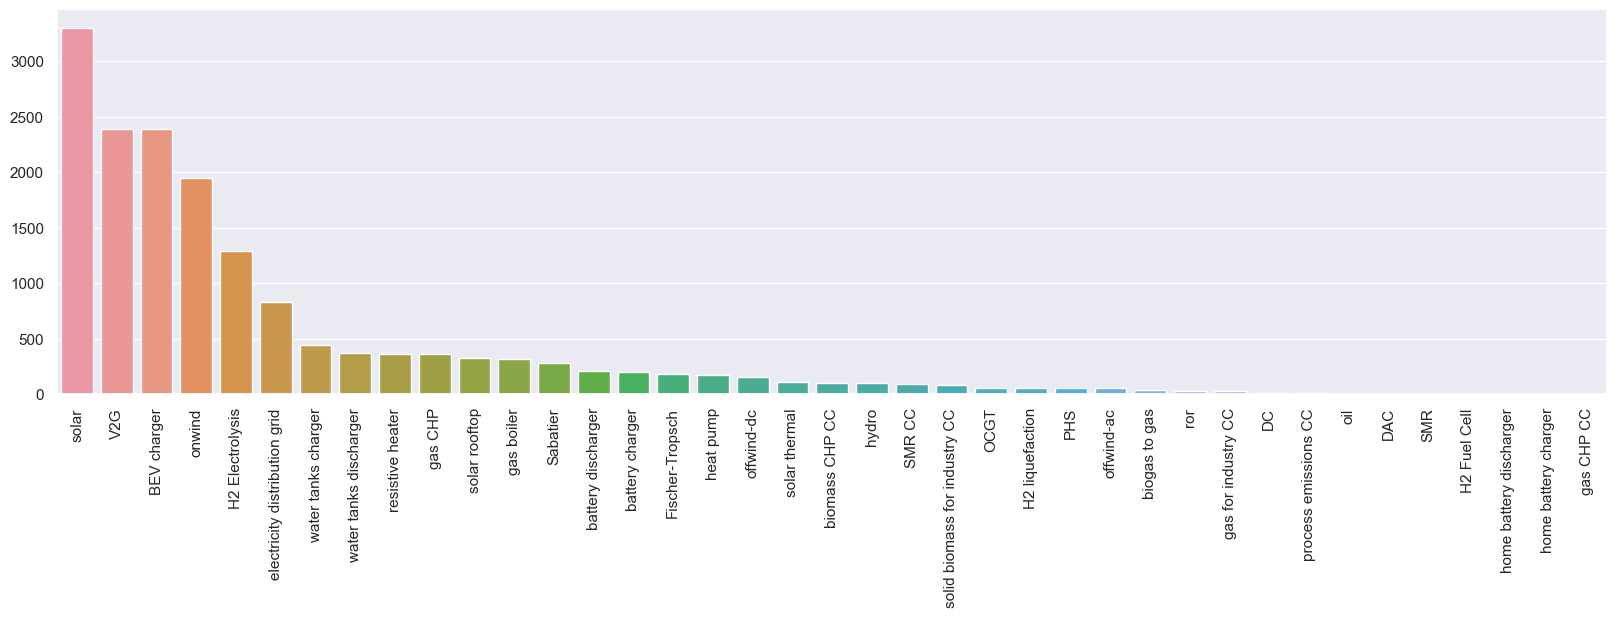

In [141]:
cap_no_sum = pd.DataFrame(cap_no.sum().sort_values(ascending=False)).transpose()
sns.set(rc={'figure.figsize': (20, 5)})
sns.barplot(data=cap_no_sum.iloc[: , 1:40])
ticks = plt.xticks(rotation=90)
plt.show()

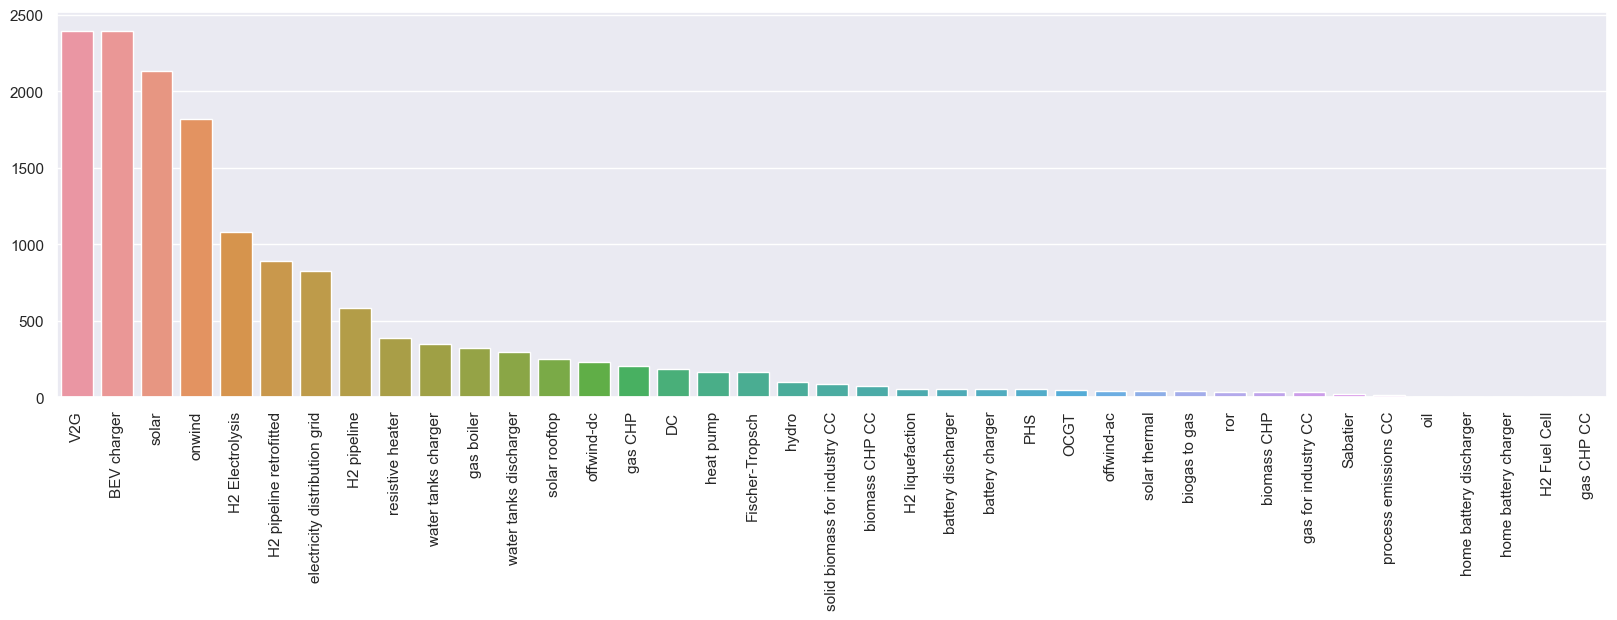

In [142]:
cap_h2_sum = pd.DataFrame(cap_h2.sum().sort_values(ascending=False)).transpose()
sns.set(rc={'figure.figsize': (20, 5)})
sns.barplot(data=cap_h2_sum.iloc[: , 1:40])
ticks = plt.xticks(rotation=90)
plt.show()

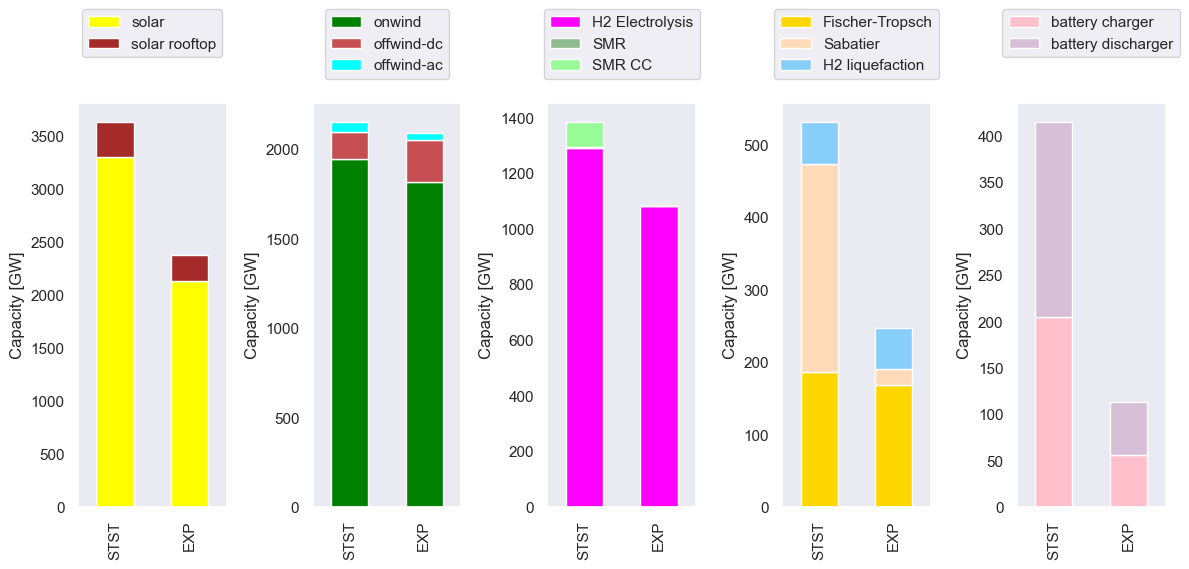

In [143]:
# thesis_plot
# capacity of important technologies

fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=5, figsize=(12, 6))
bbox = (0.5, 1.25)

carriers = ["solar" , "solar rooftop"]
get_df(cap_no_sum, cap_h2_sum, carriers).plot(ax = ax0, kind="bar", stacked=True, grid=False, color=[carrier_colors[c] for c in carriers], ylabel="Capacity [GW]")
ax0.legend(loc='upper center', bbox_to_anchor=bbox)

carriers = ["onwind", "offwind-dc", "offwind-ac"]
get_df(cap_no_sum, cap_h2_sum, carriers).plot(ax = ax1, kind="bar", stacked=True, grid=False, color=[carrier_colors[c] for c in carriers], ylabel="Capacity [GW]")
ax1.legend(loc='upper center', bbox_to_anchor=bbox)

carriers = ["H2 Electrolysis", "SMR", "SMR CC"]
get_df(cap_no_sum, cap_h2_sum, carriers).plot(ax = ax2, kind="bar", stacked=True, grid=False, color=[carrier_colors[c] for c in carriers], ylabel="Capacity [GW]")
ax2.legend(loc='upper center', bbox_to_anchor=bbox)

carriers = ["Fischer-Tropsch", "Sabatier", "H2 liquefaction"]
get_df(cap_no_sum, cap_h2_sum, carriers).plot(ax = ax3, kind="bar", stacked=True, grid=False, color=[carrier_colors[c] for c in carriers], ylabel="Capacity [GW]")
ax3.legend(loc='upper center', bbox_to_anchor=bbox)

carriers = ["battery charger", "battery discharger"]
get_df(cap_no_sum, cap_h2_sum, carriers).plot(ax = ax4, kind="bar", stacked=True, grid=False, color=[carrier_colors[c] for c in carriers], ylabel="Capacity [GW]")
ax4.legend(loc='upper center', bbox_to_anchor=bbox)

fig.tight_layout()
plt.show()

# fig.savefig(f"{PLOT_DIR}01_general/4.1_system_overview/capa_scenarios.png")

In [144]:
carriers = ["hydro"]
get_df(cap_no_sum, cap_h2_sum, carriers)

,hydro
STST,99.562201
EXP,99.562201


In [145]:
# magnitude is in GW
carriers = ["battery charger", "battery discharger"]
round(get_df(cap_no_sum, cap_h2_sum, carriers), 0).transpose() / round(get_df(cap_no_sum, cap_h2_sum, carriers), 0).transpose().sum()
# round(get_df(cap_no_sum, cap_h2_sum, carriers), 0).sum(axis=1)

,STST,EXP
battery charger,0.493976,0.495575
battery discharger,0.506024,0.504425


In [146]:
# magnitude is in GW
carriers = ["H2 Fuel Cell"]
round(get_df(cap_no_sum, cap_h2_sum, carriers), 0).transpose()
# round(get_df(cap_no_sum, cap_h2_sum, carriers), 0).sum(axis=1)

,STST,EXP
H2 Fuel Cell,1.0,0.0



Notes:
- 'H2 pipeline', 'H2 pipeline retrofitted' are the only difference in the carriers (n_no does not have them)
- H2 Fuel Cell Capacity is not really existent: capacity without H2 network is 1 GW and with H2 network it is 0


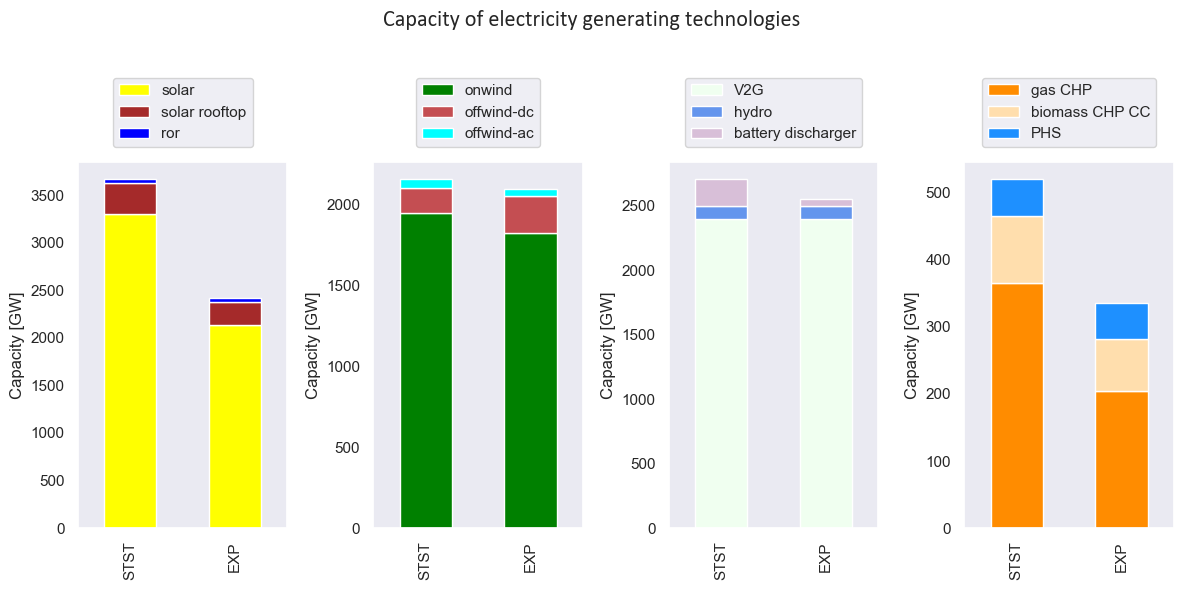

In [177]:
# capacity of electricity generating technologies

c_el_gen_s, c_el_con_s

fig, (ax0, ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=4, figsize=(12, 6))
bbox = (0.5, 1.25)

carriers = ["solar" , "solar rooftop", "ror"]
get_df(cap_no_sum, cap_h2_sum, carriers).plot(ax = ax0, kind="bar", stacked=True, grid=False, color=[carrier_colors[c] for c in carriers], ylabel="Capacity [GW]")
ax0.legend(loc='upper center', bbox_to_anchor=bbox)

carriers = ["onwind", "offwind-dc", "offwind-ac"]
get_df(cap_no_sum, cap_h2_sum, carriers).plot(ax = ax1, kind="bar", stacked=True, grid=False, color=[carrier_colors[c] for c in carriers], ylabel="Capacity [GW]")
ax1.legend(loc='upper center', bbox_to_anchor=bbox)

carriers = ["V2G", "hydro", "battery discharger"]
get_df(cap_no_sum, cap_h2_sum, carriers).plot(ax = ax2, kind="bar", stacked=True, grid=False, color=[carrier_colors[c] for c in carriers], ylabel="Capacity [GW]")
ax2.legend(loc='upper center', bbox_to_anchor=bbox)

carriers = ["gas CHP", "biomass CHP CC", "PHS"]
get_df(cap_no_sum, cap_h2_sum, carriers).plot(ax = ax3, kind="bar", stacked=True, grid=False, color=[carrier_colors[c] for c in carriers], ylabel="Capacity [GW]")
ax3.legend(loc='upper center', bbox_to_anchor=bbox)

fig.suptitle("Capacity of electricity generating technologies", fontsize=16,  **font1)
fig.tight_layout()
plt.show()

fig.savefig(f"{PLOT_DIR}01_general/4.1_system_overview/el_gen_capa_scenarios.png")

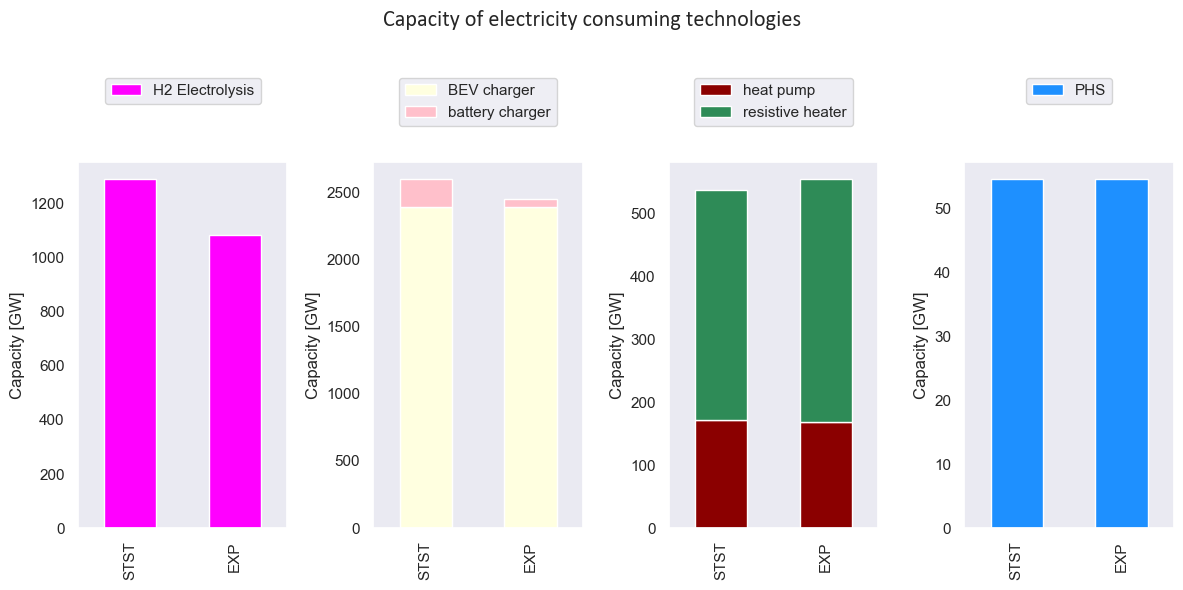

In [178]:
# capacity of electricity consuming technologies

fig, (ax0, ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=4, figsize=(12, 6))
bbox = (0.5, 1.25)

carriers = ["H2 Electrolysis"]
get_df(cap_no_sum, cap_h2_sum, carriers).plot(ax = ax0, kind="bar", stacked=True, grid=False, color=[carrier_colors[c] for c in carriers], ylabel="Capacity [GW]")
ax0.legend(loc='upper center', bbox_to_anchor=bbox)

carriers = ["BEV charger", "battery charger"]
get_df(cap_no_sum, cap_h2_sum, carriers).plot(ax = ax1, kind="bar", stacked=True, grid=False, color=[carrier_colors[c] for c in carriers], ylabel="Capacity [GW]")
ax1.legend(loc='upper center', bbox_to_anchor=bbox)

carriers = ["heat pump", "resistive heater"]
get_df(cap_no_sum, cap_h2_sum, carriers).plot(ax = ax2, kind="bar", stacked=True, grid=False, color=[carrier_colors[c] for c in carriers], ylabel="Capacity [GW]")
ax2.legend(loc='upper center', bbox_to_anchor=bbox)

carriers = ["PHS"]
get_df(cap_no_sum, cap_h2_sum, carriers).plot(ax = ax3, kind="bar", stacked=True, grid=False, color=[carrier_colors[c] for c in carriers], ylabel="Capacity [GW]")
ax3.legend(loc='upper center', bbox_to_anchor=bbox)

fig.suptitle("Capacity of electricity consuming technologies", fontsize=16,  **font1)
fig.tight_layout()
plt.show()

fig.savefig(f"{PLOT_DIR}01_general/4.1_system_overview/el_con_capa_scenarios.png")

In [ ]:
# capacity of peak power plants

fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=5, figsize=(12, 6))
bbox = (0.5, 1.25)

carriers = ["gas CHP CC", "gas CHP"]
get_df(cap_no_sum, cap_h2_sum, carriers).plot(ax = ax0, kind="bar", stacked=True, grid=False, color=[carrier_colors[c] for c in carriers], ylabel="Capacity [GW]")
ax0.legend(loc='upper center', bbox_to_anchor=bbox)

carriers = ["hydro", "PHS"]
get_df(cap_no_sum, cap_h2_sum, carriers).plot(ax = ax1, kind="bar", stacked=True, grid=False, color=[carrier_colors[c] for c in carriers], ylabel="Capacity [GW]")
ax1.legend(loc='upper center', bbox_to_anchor=bbox)


carriers = ["biomass CHP CC" , "biomass CHP"]
get_df(cap_no_sum, cap_h2_sum, carriers).plot(ax = ax2, kind="bar", stacked=True, grid=False, color=[carrier_colors[c] for c in carriers], ylabel="Capacity [GW]")
ax2.legend(loc='upper center', bbox_to_anchor=bbox)

carriers = ["OCGT"]
get_df(cap_no_sum, cap_h2_sum, carriers).plot(ax = ax3, kind="bar", stacked=True, grid=False, color=[carrier_colors[c] for c in carriers], ylabel="Capacity [GW]")
ax3.legend(loc='upper center', bbox_to_anchor=bbox)

carriers = ["V2G"]
get_df(cap_no_sum, cap_h2_sum, carriers).plot(ax = ax4, kind="bar", stacked=True, grid=False, color=[carrier_colors[c] for c in carriers], ylabel="Capacity [GW]")
ax4.legend(loc='upper center', bbox_to_anchor=bbox)

fig.tight_layout()
plt.show()

# fig.savefig(f"{PLOT_DIR}01_general/4.1_system_overview/capa_peak_scenarios.png")

#### Generation

In [ ]:
# thesis_plot:

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 11))

for n in [n_no, n_h2]:

    carrier = ["AC", "low voltage"]
    nb = nodal_balance(n, carrier=carrier, time="2013", aggregate=['component', 'bus'], energy=True)
    # convert from MWh to GWh
    nb = nb.unstack(level=[1]) / 1000
    # condense condense_groups
    nb = get_condense_sum(nb, c1_groups, c1_groups_name)
    # rename unhandy column names
    nb.rename(columns=carrier_renaming, inplace=True)

    nb_pos = nb[nb > 0].sum().sort_values(ascending=False)
    # exclude all shares smaller than 1 %
    nb_pos = nb_pos[(nb_pos / nb_pos.sum()) > 0.01]

    nb_neg = abs(nb[nb < 0].sum()).sort_values(ascending=False)
    # exclude all shares smaller than 1 %
    nb_neg = nb_neg[(nb_neg / nb_neg.sum()) > 0.01]

    if n==n_no:
        ax_gen=axs[0, 0]
        ax_con=axs[0, 1]
        title_gen=f"Electricity generation (STST)"
        title_con=f"Electricity consumption (STST)"

    elif n==n_h2:
        ax_gen=axs[1, 0]
        ax_con=axs[1, 1]
        title_gen=f"Electricity generation (EXP)"
        title_con=f"Electricity consumption (EXP)"

    # generation
    c = [carrier_colors[col] for col in nb_pos.index]
    percents = nb_pos.to_numpy() * 100 / nb_pos.to_numpy().sum()
    labels = ['%s (%1.1f %%)' % (l, s) for l, s in zip(nb_pos.index, percents)]

    patches, texts = ax_gen.pie(nb_pos, colors=c, startangle=0, labels=labels)
    ax_gen.axis('equal')
    ax_gen.set_title(title_gen, pad=20, fontweight="bold")

    # consumption
    c = [carrier_colors[col] for col in nb_neg.index]
    percents = nb_neg.to_numpy() * 100 / nb_neg.to_numpy().sum()
    labels = ['%s (%1.1f %%)' % (l, s) for l, s in zip(nb_neg.index, percents)]

    patches, texts = ax_con.pie(nb_neg, colors=c, startangle=0, labels=labels)
    ax_con.axis('equal')

    ax_con.set_title(title_con, pad=20, fontweight="bold")

fig.tight_layout(pad=5)
plt.show()

# fig.savefig(f"{PLOT_DIR}01_general/4.1_system_overview/gen_con_ac_lowvoltage.png")

In [ ]:
nb[nb > 0].sum().sort_values(ascending=False) / nb[nb > 0].sum().sort_values(ascending=False).sum()

In [ ]:
# overall electricity generation in TWh

carrier = ["AC", "low voltage"]
nb = nodal_balance(n_h2, carrier=carrier, time="2013", aggregate=['component', 'bus'], energy=True)
# convert from MWh to GWh
nb = nb.unstack(level=[1]) / 1000
# condense condense_groups
nb = get_condense_sum(nb, c1_groups, c1_groups_name)
# rename unhandy column names
nb.rename(columns=carrier_renaming, inplace=True)
# calc sum and convert to TWh
nb[nb > 0].sum().sum() / 1000

# STST: 10202
# EXP: 9172

In [ ]:
# overall generation and share of all wind and solar technologies:
# wind:  STST: 5347 TWh, 52 % ; EXP: 5708 TWh, 62 %
# solar: STST: 3584 TWh, 35 %; EXP: 2603 TWh, 28 %
# Together: STST: 8931 TWh, 88 % ; EXP: 8311 TWh, 91 \%
# (nb[nb > 0].sum()[["solar", "solar rooftop"]].sum() / 1000 ) / (nb[nb > 0].sum().sum() / 1000)
(nb[nb > 0].sum()[["onwind", "offwind-ac", "offwind-dc", "solar", "solar rooftop"]].sum() / 1000 ) #/ (nb[nb > 0].sum().sum() / 1000)


In [135]:
# overall electricity consumption in TWh

carrier = ["AC", "low voltage"]
nb = nodal_balance(n_no, carrier=carrier, time="2013", aggregate=['component', 'bus'], energy=True)
# convert from MWh to GWh
nb = nb.unstack(level=[1]) / 1000
# condense condense_groups
nb = get_condense_sum(nb, c1_groups, c1_groups_name)
# rename unhandy column names
nb.rename(columns=carrier_renaming, inplace=True)
# calc sum and convert to TWh
nb[nb < 0].sum().sum() / 1000

# STST: -10202
# EXP: -9172

-10202.074411189566

In [137]:
# Direct Air Capture consumes 12 TWh in total? (STST)
nb[nb < 0].sum()["DAC"] / 1e3

-12.91278952837588

In [ ]:
# generation and consumption (heat)

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 11))

for n in [n_no, n_h2]:

    carrier = ["urban central heat"]
    nb = nodal_balance(n, carrier=carrier, time="2013", aggregate=['component', 'bus'], energy=True)
    # convert from MW to GW
    nb = nb.unstack(level=[1]) / 1000

    nb_pos = nb.sum()[nb.sum() > 0].sort_values(ascending=False)
    # exclude all shares smaller than 1 %
    nb_pos = nb_pos[(nb_pos / nb_pos.sum()) > 0.01]

    nb_neg = abs(nb.sum()[nb.sum() < 0]).sort_values(ascending=False)
    # exclude all shares smaller than 1 %
    nb_neg = nb_neg[(nb_neg / nb_neg.sum()) > 0.01]

    if n==n_no:
        ax_gen=axs[0, 0]
        ax_con=axs[0, 1]
        title_gen=f"Generation: {carrier} (STST)"
        title_con=f"Consumption: {carrier} (STST)"

    elif n==n_h2:
        ax_gen=axs[1, 0]
        ax_con=axs[1, 1]
        title_gen=f"Generation: {carrier} (EXP)"
        title_con=f"Consumption: {carrier} (EXP)"

    # generation
    c = [carrier_colors[col] for col in nb_pos.index]
    percents = nb_pos.to_numpy() * 100 / nb_pos.to_numpy().sum()
    labels = ['%s (%1.1f %%)' % (l, s) for l, s in zip(nb_pos.index, percents)]

    patches, texts = ax_gen.pie(nb_pos, colors=c, startangle=0, labels=labels)
    ax_gen.axis('equal')
    ax_gen.set_title(title_gen, pad=20, fontweight="bold")

    # consumption
    c = [carrier_colors[col] for col in nb_neg.index]
    percents = nb_neg.to_numpy() * 100 / nb_neg.to_numpy().sum()
    labels = ['%s (%1.1f %%)' % (l, s) for l, s in zip(nb_neg.index, percents)]

    patches, texts = ax_con.pie(nb_neg, colors=c, startangle=0, labels=labels)
    ax_con.axis('equal')

    ax_con.set_title(title_con, pad=20, fontweight="bold")

fig.tight_layout(pad=2)
plt.show()

# Fischer Tropsch nebenprdukt Heat

#### Correlation of Capacity

In [ ]:
cap_no.corr()["PHS"].sort_values(ascending=False)

In [ ]:
cap_h2.corr()["H2 pipeline retrofitted"].sort_values(ascending=False)

In [ ]:
# check correlation of capacities to check at which locations similar technologies are present
fig = plt.figure(figsize=(28, 14))
sns.heatmap(cap_no.corr()[(abs(cap_no.corr()) > 0.1) & (abs(cap_no.corr()) < 0.8)], annot=True)
plt.close()
plt.show()
# fig.savefig(f"{PLOT_DIR}01_general/4.1_system_overview/no_h2_capa_corr.png")

In [ ]:
# check correlation of capacities to check at which location similar technologies are present
fig = plt.figure(figsize=(28, 14))
sns.heatmap(cap_h2.corr()[(abs(cap_h2.corr()) > 0.6) & (abs(cap_h2.corr()) < 0.9)], annot=True)
plt.show()
# fig.savefig(f"{PLOT_DIR}01_general/4.1_system_overview/h2_capa_corr.png")

In [ ]:
fig = plt.figure(figsize=(28, 14))
diff_cap = cap_no.corr() - cap_h2.corr()
sns.heatmap(diff_cap[(abs(diff_cap) > 0.4) & (abs(diff_cap) < 0.5)], annot=True)
plt.close()
plt.show()
# fig.savefig(f"{PLOT_DIR}01_general/4.1_system_overview/capa_corr_diff_no_minus_h2.png")

Findings: correlation of capacities amogn the scenarios

Interesting and making sense:
- H2 Electrolysis and onwind: (no: 0.67; h2: 0.76) -> onshore wind dominantly used for hydrogen production
- H2 Electrolysis and solar: (no: 0.32; h2: 0.37) -> solar wind partly used for hydrogen production
- H2 Electrolysis and H2 pipeline: 0.66 -> hydrogen production at locations with pipelines
- onwind and h2 pipeline. 0.57 -> onwind used for hydrogen production close to h2 pipelines; pipelines are build where a lot of onwind is located
- offwind-dc and H2 liquefaction: 0.61 ; 0.35 -> offshore wind used to produced liquefied hydrogen (more present in STST scenario as there is less possibility to transport away the offshore wind power generation)

- solar and battery charger: (no: 0.59; h2: 0.54) -> solar used for utility scale battery charging
- BEV and solar rooftop: (STST: 0.63 ; EXP: 0.56) -> solar used to charge vehicles
- BEV and solar: (STST: 0.53 ; EXP: 0.22) -> solar used to charge vehicles

- gas CHP and heat pump / gas boilder / resistive heater : (no: 0.83, 0.72, 0.72 ; h2: 0.71 , 0.7, 0.58) -> all heat sources are at the same location
- gas CHP and biomass CHP / biomas CHP CC: 0.67 / 0.67 ; 0.44 / 0.3 -> all heat sources are at the same location
- gas CHP and water tanks charger: 0.66 ; 0.53 -> heat used for charging thermal storage
- water tanks charger and heat pump / gas boiler / resisitive heater: 0.68 / 0.65 / 0.67 ; 0.73/ 0.72 / 0.65 -> heat used for charging thermal storage

Not making sense or not interesting?:
- biomas CHP and water tanks charger / discharger; (no: 0.007/ 0.048 ; h2: 0.59, 0.55) -> Why no correlation in STST case?
- biomass CHP and home battery charger: -0.52 ; -0.23
- gas CHP CC and home battery charger: -0.65 ; -0.7
- H2 Electrolysis and water tanks charger / water tanks discharger: ( no: 0.39 / 0.44 ; -0.12 / < abs(0.1)) -> rather random?

Not interesting and making sense:
- solar and solar rooftop (0.5 ; 0.47)
- solar thermal and solar: 0.56 ; 0.41

Not interesting and not making sense:
- H2 Fuel cell and home battery charger / home battery discharger: (no: -0.032; h2: -0.69) not very relevant as there is almost no capacity of fuel cell
- SMR CC and H2 liquefaction: (no: 0.72; h2: -0.16) strong correlation with SMR CC and H2 liquefaction in STST scenario; small correlation in EXP scenario random due to little capacity of SMR CC
- H2 Fuel Cell and biomass CHP / biomass CHP CC: (no: 0.032 / <0.01 ; ) H2 Fuel Cell has no relevance

#### Capacity Coverage (%)
- calc capacities in percentage
- calc the min(capA, capB) for every location to see how many percentage points are present at a location from both technologies. If it is 100, the distributio of capacity is the same, if it is 0, there is no capacity present of technology A at the same location where capacity of technology B is present.
- measure the similarity of the distribution
how to calc that?

In [ ]:
# Note: gas, oil, sabatier, biogas to gas, ... only have capacity at EU bus

cap_no_perc = pd.DataFrame(cap_no.fillna(0) / cap_no.fillna(0).sum())
cap_h2_perc = pd.DataFrame(cap_h2.fillna(0) / cap_h2.fillna(0).sum())

# exclude all carriers that only have capacity at EU bus
cap_no_perc = cap_no_perc[cap_no_perc.columns[cap_no_perc.loc["EU"]!=1]]
cap_h2_perc = cap_h2_perc[cap_h2_perc.columns[cap_h2_perc.loc["EU"]!=1]]

# drop EU row
cap_no_perc.drop("EU", inplace=True)
cap_h2_perc.drop("EU", inplace=True)

cap_no_cc = pd.DataFrame(index=cap_no_perc.columns, columns=cap_no_perc.columns)
cap_h2_cc = pd.DataFrame(index=cap_h2_perc.columns, columns=cap_h2_perc.columns)

for c1 in cap_no_cc.columns:
    for c2 in cap_no_cc.index:
        cap_no_cc.loc[c1, c2] = cap_no_perc[[c1, c2]].min(axis=1).sum()

for c1 in cap_h2_cc.columns:
    for c2 in cap_h2_cc.index:
        cap_h2_cc.loc[c1, c2] = cap_h2_perc[[c1, c2]].min(axis=1).sum()

# convert to float
cap_no_cc = cap_no_cc.astype(float)
cap_h2_cc = cap_h2_cc.astype(float)

In [ ]:
fig = plt.figure(figsize=(28, 14))
sns.heatmap(cap_no_cc[cap_no_cc >0.8], annot=True)
plt.close()
plt.show()

In [ ]:
fig = plt.figure(figsize=(28, 14))
sns.heatmap(cap_h2_cc[cap_h2_cc > 0.8], annot=True)
plt.close()
plt.show()

In [ ]:
round(cap_no_cc - cap_h2_cc.loc[cap_no_cc.index, cap_no_cc.columns], 2)

In [ ]:
fig = plt.figure(figsize=(28, 14))
diff_cc = round(cap_no_cc - cap_h2_cc.loc[cap_no_cc.index, cap_no_cc.columns], 2)
sns.heatmap(diff_cc[abs(diff_cc) > 0.5], annot=True)
plt.close()
plt.show()

### Correlation of generation
- temporal correlation
- spatial correlation

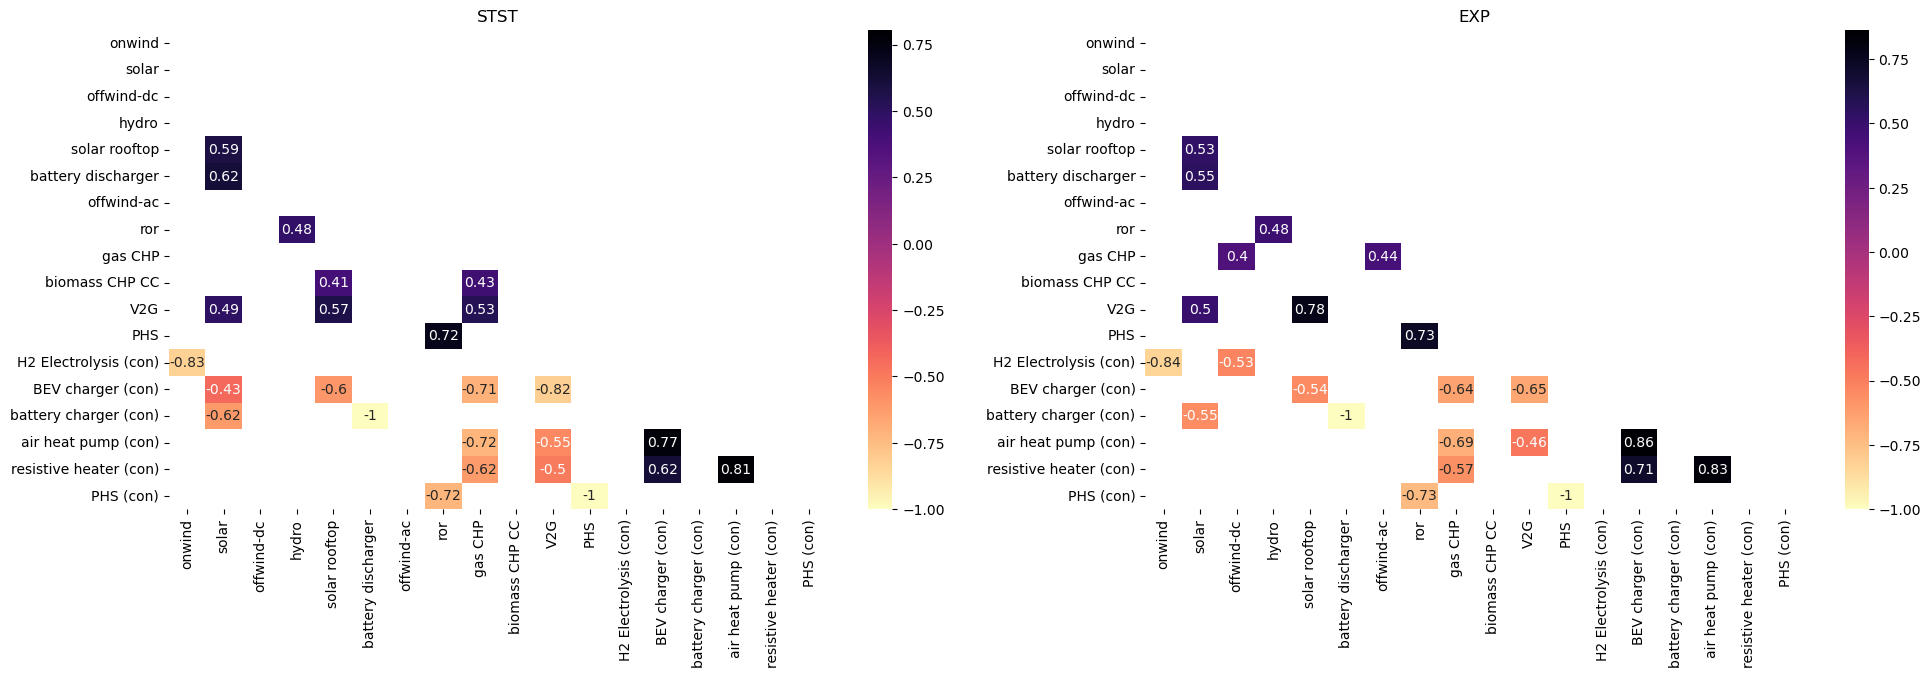

In [120]:
# Spatial correlation of gen STST and EXP
# correlation of the whole generation and consumption aggregated for all locations

fig, axs = plt.subplots(ncols=2, figsize=(20, 7))

for i, df, ax in zip([0,1], [df_stst_ons, df_exp_ons], axs):
    corr = df[[c + "_gen" for c in c_el_gen_s] + [c + "_con_el" for c in c_el_con_s]].corr()
    corr.index = [carrier_renaming.get(n, n) for n in c_el_gen_s] + [carrier_renaming.get(n, n) + " (con)" for n in c_el_con_s]
    corr.columns = [carrier_renaming.get(n, n) for n in c_el_gen_s] + [carrier_renaming.get(n, n)+ " (con)" for n in c_el_con_s]

    mask = np.triu(np.ones_like(corr, dtype=bool))

    sns.heatmap(corr[abs(corr) > 0.4], mask=mask, cmap="magma_r", annot=True, ax=ax)
    ax.set_title('STST' if i == 0 else 'EXP')
    
fig.tight_layout(pad=1.5)
plt.close()
plt.show()

#fig.savefig(f"{PLOT_DIR}01_general/4.1_system_overview/el_gen_con_spatial_corr.png")

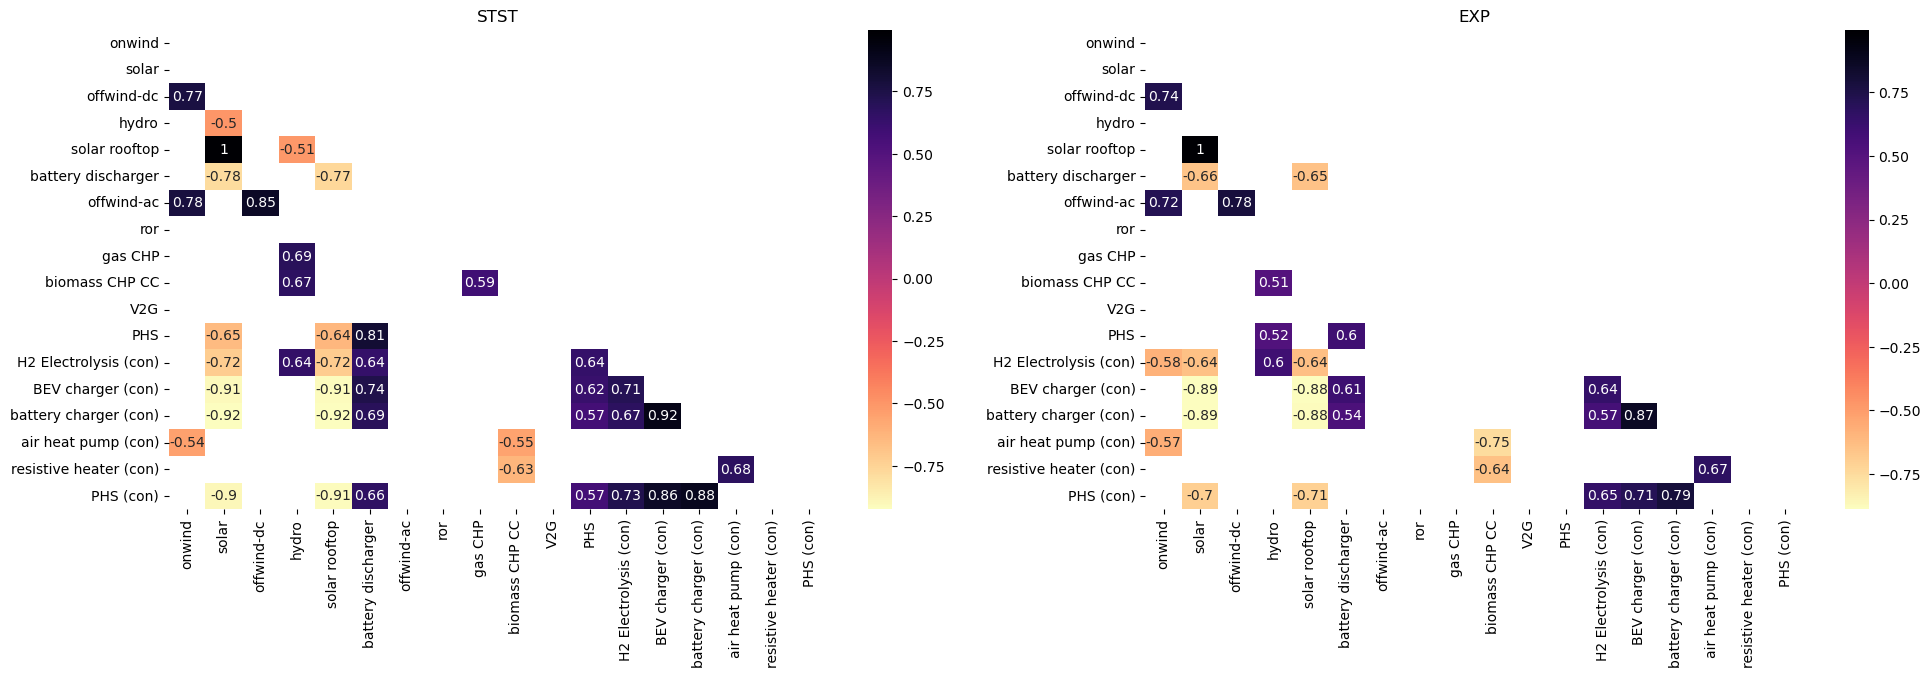

In [121]:
# temporal correlation of gen STST and EXP (1)
# correlation of the generation / consumption per time step aggregated over the locations

fig, axs = plt.subplots(ncols=2, figsize=(20, 7))

for i, df, ax in zip([0,1], [df_stst_ts, df_exp_ts], axs):
    corr = df[[c + "_gen" for c in c_el_gen_s] + [c + "_con_el" for c in c_el_con_s]].corr()
    corr.index = [carrier_renaming.get(n, n) for n in c_el_gen_s] + [carrier_renaming.get(n, n) + " (con)" for n in c_el_con_s]
    corr.columns = [carrier_renaming.get(n, n) for n in c_el_gen_s] + [carrier_renaming.get(n, n)+ " (con)" for n in c_el_con_s]

    mask = np.triu(np.ones_like(corr, dtype=bool))

    sns.heatmap(corr[abs(corr) > 0.4], mask=mask, cmap="magma_r", annot=True, ax=ax)
    ax.set_title('STST' if i == 0 else 'EXP')
    
    
fig.tight_layout(pad=1.5)
plt.close()
plt.show()

#fig.savefig(f"{PLOT_DIR}01_general/4.1_system_overview/el_gen_con_temporal_corr.png")

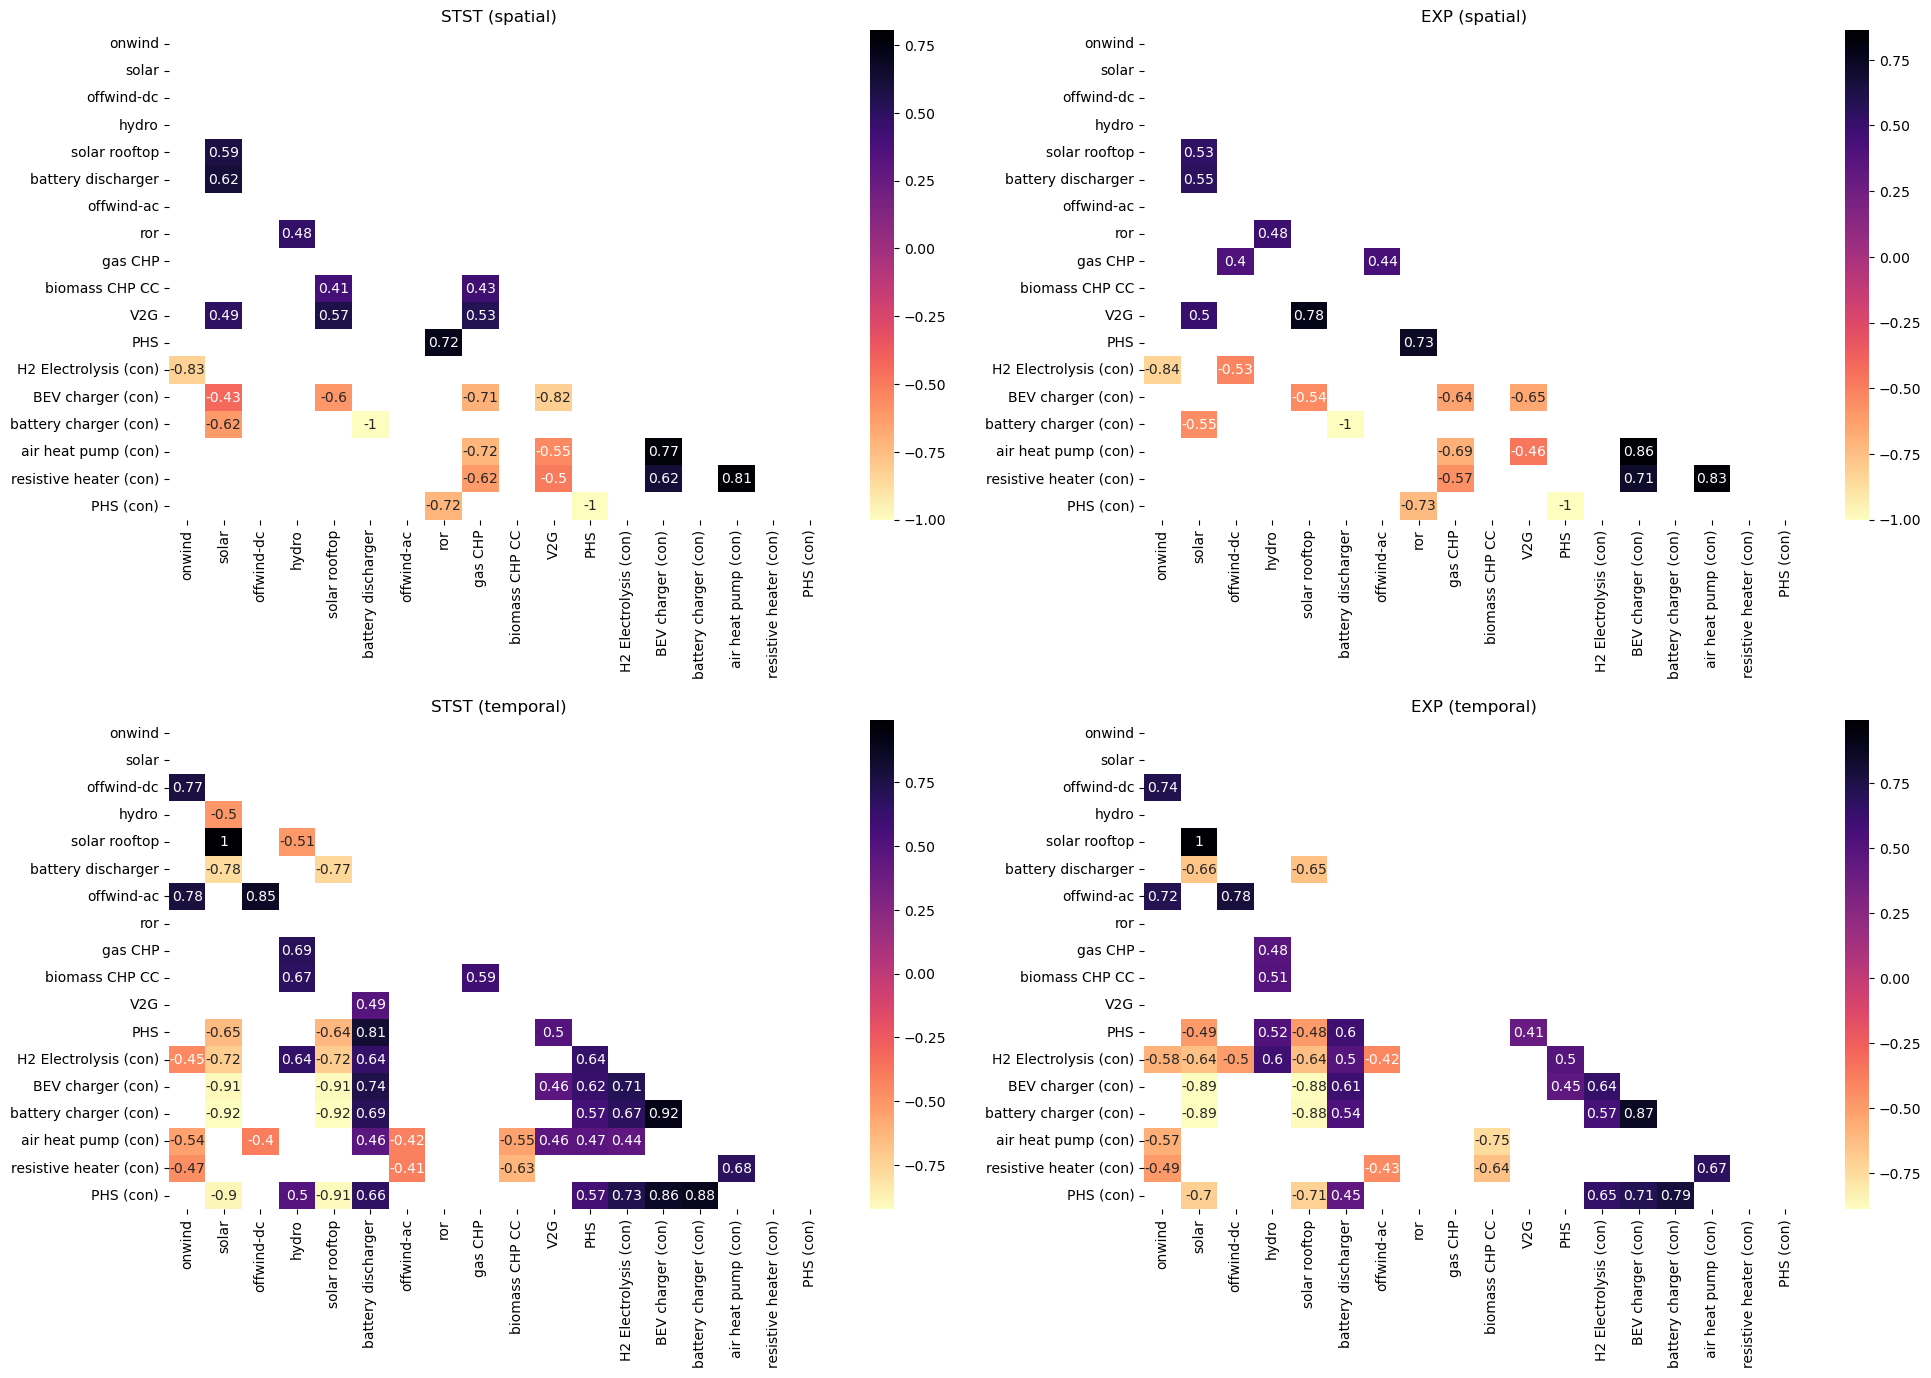

In [122]:
# Spatial and temporal correlation of gen STST and EXP

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 14))

for title, df, ax in zip(["STST (spatial)", "EXP (spatial)", "STST (temporal)", "EXP (temporal)"], [df_stst_ons, df_exp_ons, df_stst_ts, df_exp_ts], axs.reshape(-1)):
    corr = df[[c + "_gen" for c in c_el_gen_s] + [c + "_con_el" for c in c_el_con_s]].corr()
    corr.index = [carrier_renaming.get(n, n) for n in c_el_gen_s] + [carrier_renaming.get(n, n) + " (con)" for n in c_el_con_s]
    corr.columns = [carrier_renaming.get(n, n) for n in c_el_gen_s] + [carrier_renaming.get(n, n)+ " (con)" for n in c_el_con_s]

    mask = np.triu(np.ones_like(corr, dtype=bool))

    sns.heatmap(corr[abs(corr) > 0.4], mask=mask, cmap="magma_r", annot=True, ax=ax)
    ax.set_title(title)
    
fig.tight_layout(pad=1.5)
#plt.close()
plt.show()

#fig.savefig(f"{PLOT_DIR}01_general/4.1_system_overview/el_gen_con_spatial_temporal_corr.png")

In [33]:
def get_generation(carrier = "onwind", n=n_no, period="2013"):

    if carrier in n.generators.carrier.unique().tolist():
        result = n.generators_t.p.loc[period, n.generators.carrier == carrier]
        result.columns = result.columns.map(n.generators.bus)
        result.columns = result.columns.map(n.buses.location)

    elif carrier in n.links.carrier.unique().tolist():
        result = -n.links_t.p1.loc[period, n.links.carrier == carrier]
        result.columns = result.columns.map(n.links.bus1)
        result = result.groupby(result.columns, axis=1).sum()
        result.columns = result.columns.map(n.buses.location)

    elif carrier in n.storage_units.carrier.unique().tolist():
        result = n.storage_units_t.p_dispatch.loc[period, n.storage_units.carrier == carrier]
        result.columns = result.columns.map(n.storage_units.bus)
        result.columns = result.columns.map(n.buses.location)

    elif carrier in n.loads.carrier.unique().tolist():
        result = n.loads_t.p.loc[period, n.loads.carrier == carrier]
        result.columns = result.columns.map(n.loads.bus)
        result.columns = result.columns.map(n.buses.location)

    else:
        result = None

    return result

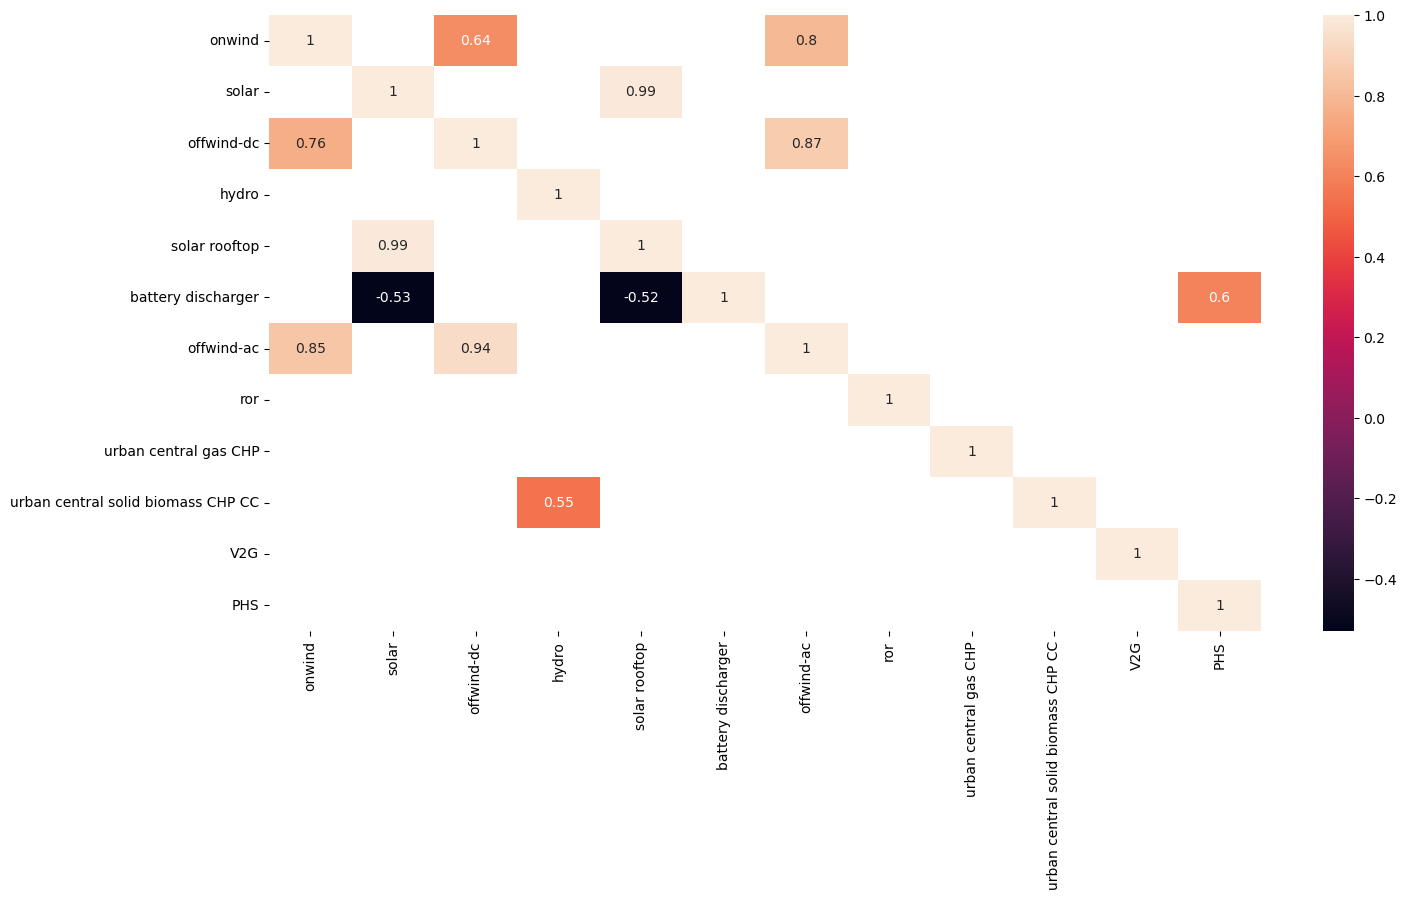

In [110]:
# generation weighted temporal correlation per location
# corr calculated as: correlation of ts of every time step and every location with all locations ->y 181 correlations; 
# then taking the generation weighted average of these correlations

carriers = c_el_gen_s
n = n_no
res_temp_n_no = pd.DataFrame(index=carriers, columns=carriers)

for c1 in carriers:
    for c2 in carriers:

        gen1 = get_generation(carrier=c1, n=n)
        gen2 = get_generation(carrier=c2, n=n)

        com_cols = gen1.columns.intersection(gen2.columns)
        loc_res = pd.DataFrame(index=com_cols, columns=["corr"])

        for loc in com_cols:
            loc_res.loc[loc,"corr"] = gen1[loc].corr(gen2[loc])

        # correlation of two vectors with constant values is nan
        loc_res.dropna(inplace=True)

        # generation weighted mean of correlations per location
        res_temp_n_no.loc[c1,c2] = round((gen1[loc_res.index].sum() * loc_res.T / gen1[loc_res.index].sum().sum()).sum().sum(), 2)

res_temp_n_no = res_temp_n_no.astype("float")

fig = plt.figure(figsize=(16, 8))
sns.heatmap(res_temp_n_no[abs(res_temp_n_no) > 0.5], annot=True)
plt.close()
plt.show()

## Energy Flow

### Balance map

In [ ]:
# plot map with overall balance of hydrogen and electricity per region

![](../../../../Pictures/Screenshots/Screenshot_20230215_101123.png)

In [ ]:
# carrier of buses are the same for the networks
n_h2.buses.carrier.unique().tolist() == n_no.buses.carrier.unique().tolist()

In [ ]:
n_h2.buses.carrier.unique().tolist()

In [ ]:
test = nodal_balance(n_no, carrier=["AC", "low voltage", "H2", "gas", "oil"], aggregate=["component", "snapshot", "carrier"], time="2013", energy=True)

In [ ]:
test

In [ ]:
test2 = nodal_balance(n_no, carrier=["AC", "low voltage"],aggregate=["component", "snapshot", "carrier"], time="2013", energy=True)
test2

In [ ]:
test.groupby(["bus"]).sum()

In [ ]:
# oil, gas, co2 is only at EU level
carrier_sets = [["AC", "low voltage"], ["H2"], ["urban central heat"], ["AC", "low voltage", "H2"]]

for carrier_set in carrier_sets:
    # nodal balance in MWh
    df_no_ons[f"{carrier_set}_nb"] = nodal_balance(n_no, carrier=carrier_set, time="2013", aggregate=["component", "snapshot", "carrier"], energy=True)
    df_h2_ons[f"{carrier_set}_nb"] = nodal_balance(n_h2, carrier=carrier_set, time="2013", aggregate=["component", "snapshot", "carrier"], energy=True)

df_no_ons.iloc[: , -10:].head()

In [ ]:
# nodal balance electricity and hydrogen
carrier_sets_plot = [["AC", "low voltage"], ["AC", "low voltage"], ["H2"], ["H2"]]

fig, axs = plt.subplots(ncols=2, nrows=2, subplot_kw={'projection': ccrs.EqualEarth()},
                        figsize=(18, 16))
crs = ccrs.EqualEarth()

for i, ax in enumerate(axs.reshape(-1)):

    if i in [0,2]:
        df = df_no_ons
        title = "(STST)"
    elif i in [1,3]:
        df = df_h2_ons
        title = "(EXP)"

    ax.add_feature(cartopy.feature.BORDERS, edgecolor='black', linewidth=0.5)
    ax.coastlines(edgecolor='black', linewidth=0.5)
    ax.set_facecolor('white')
    ax.add_feature(cartopy.feature.OCEAN, color='azure')

    df.to_crs(crs.proj4_init).plot(column=f"{carrier_sets_plot[i]}_nb",
                                                   ax=ax,
                                                   cmap=plt.get_cmap("magma_r"),
                                                   linewidth=0.05,
                                                   edgecolor = 'grey',
                                                   legend=True,
                                                   legend_kwds={'label':"total balance [MWh]",
                            'orientation': "vertical",
                                      'shrink' : 0.9})

    ax.set_title(f"{carrier_sets_plot[i]} {title}", fontsize=16, **font1)
plt.show()

In [ ]:
# Figure 6 in Neumann paper
carrier = ["AC", "low voltage", "H2", "gas", "oil"]
nb = nodal_balance(n_h2, carrier=n_h2.buses.carrier.unique().tolist(), time="2013", aggregate=["component", "snapshot", "carrier"], energy=True)

In [ ]:
nb.describe()

### Balance Flow

![](../../../../Pictures/Screenshots/Screenshot_20230215_101816.png)

In [123]:
n_no.lines_t.p0.sum()

Line
1     -1.187061e+06
10     8.523414e+06
100    4.419293e+06
101    9.065389e+05
102   -1.000031e+06
           ...     
95     9.479547e+05
96    -8.982532e+04
97     1.619466e+05
98     8.198081e+05
99    -1.042867e+06
Length: 323, dtype: float64

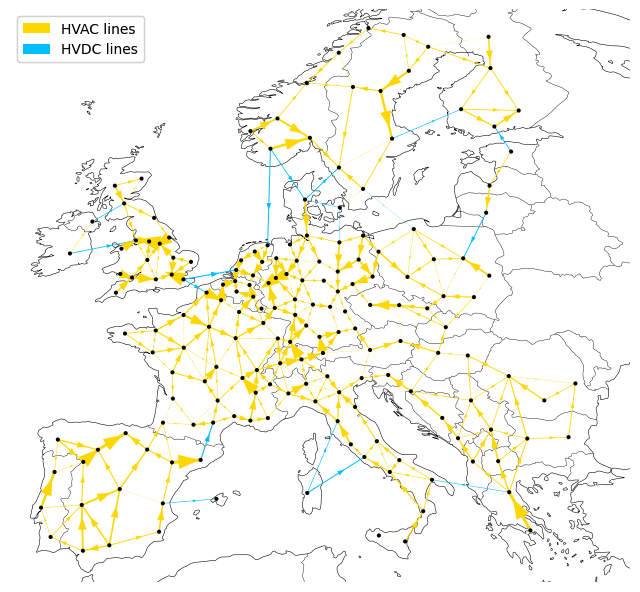

In [124]:
# Electricity network

fig, ax = plt.subplots(1, 1, subplot_kw={"projection": ccrs.EqualEarth()}, figsize=(8, 8))

m_no.plot(ax=ax, projection=ccrs.EqualEarth(), bus_colors="black", line_colors="gold", link_colors="deepskyblue",
          line_widths=5e-4, link_widths=1e-3, flow="sum")
pypsa.plot.add_legend_patches(ax=ax, labels=["HVAC lines", "HVDC lines"], colors=["gold","deepskyblue"], legend_kw={'loc': 'upper left'})
plt.show()